In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import LinearSVC,SVC
import timeit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score,precision_score,recall_score,RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

In [2]:
x_resampled=pd.read_csv('resampled_without_encoding.csv')
x_resampled_encoding=pd.read_csv('resampled_with_encoding.csv')
y_resampled=pd.read_csv('y_resampled.csv')

### Data with Resampling and with OneHotEncoding

In [3]:
X = x_resampled_encoding.values
Y = np.squeeze(y_resampled.values)
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler().fit(X_train)
train_sc = scaler.transform(X_train)
test_sc = scaler.transform(X_test)

svm_clf = LinearSVC(random_state=48) 
start_time = timeit.default_timer()
svm_clf.fit(train_sc,y_train)
elapsed = timeit.default_timer() - start_time
print("Time taken to fit the model in sec is ",elapsed)

y_pred=svm_clf.predict(test_sc)
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 score : {f1_score(y_test, y_pred):.4f}")
print(f"Recall score : {recall_score(y_test, y_pred):.4f}")
print(f"Precision score : {precision_score(y_test, y_pred):.4f}")

Time taken to fit the model in sec is  607.1905270999999
Accuracy score: 0.9005
F1 score : 0.8974
Recall score : 0.8681
Precision score : 0.9289


<AxesSubplot:>

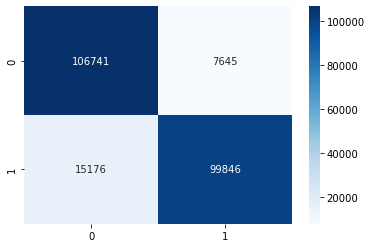

In [4]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='',cmap='Blues')

In [5]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90    114386
           1       0.93      0.87      0.90    115022

    accuracy                           0.90    229408
   macro avg       0.90      0.90      0.90    229408
weighted avg       0.90      0.90      0.90    229408



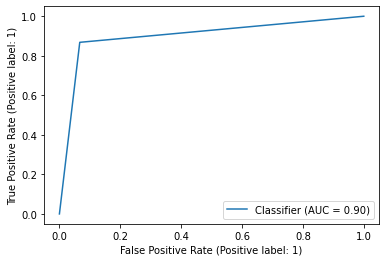

In [6]:
RocCurveDisplay.from_predictions(y_test, y_pred)

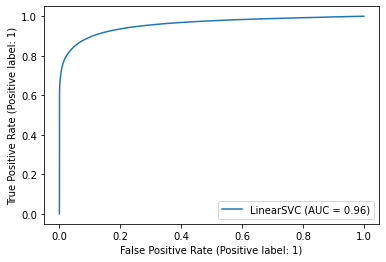

In [7]:
RocCurveDisplay.from_estimator(svm_clf, test_sc, y_test)

### Feature Importance

<BarContainer object of 212 artists>

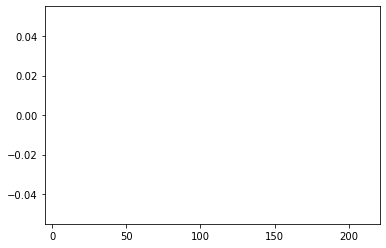

In [8]:
from sklearn.feature_selection import SelectPercentile, f_classif
import matplotlib.pyplot as plt
from sklearn import svm
X_indices = np.arange(X.shape[-1])
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, Y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(np.arange(X.shape[-1]) - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='g')

In [11]:

# Compare to the weights of an SVM
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()
svm_weights

array([4.82311947e-05, 8.93654342e-05, 1.00000000e+00, 8.33075651e-01,
       9.13603388e-01, 9.79510496e-01, 2.98247142e-01, 3.09974006e-01,
       4.03912714e-01, 3.21945349e-01, 1.71212225e-01, 8.84782652e-05,
       8.28897245e-02, 1.39301142e-01, 1.56340398e-01, 1.45072258e-03,
       2.06941644e-03, 2.51934503e-03, 1.30676481e-02, 2.29410475e-02,
       2.05140337e-04, 2.78931807e-05, 2.16820200e-08, 4.87436935e-05,
       1.19027505e-03, 1.16923305e-03, 4.60619068e-04, 5.29764259e-04,
       3.59503544e-04, 8.44099329e-04, 3.83980701e-05, 8.33509947e-05,
       1.24209843e-03, 3.10275443e-04, 3.82219660e-05, 3.75144161e-02,
       9.92955269e-03, 1.06961275e-02, 2.01857857e-02, 1.75195149e-02,
       2.95378303e-02, 7.24353218e-03, 3.90008164e-06, 1.06976101e-03,
       2.95681510e-03, 2.67689735e-03, 2.67689735e-03, 5.51140299e-03,
       1.03580861e-03, 7.17376232e-03, 8.92470700e-04, 5.40435397e-03,
       2.20281876e-02, 7.68666409e-03, 4.24684389e-04, 5.02347399e-05,
      

<BarContainer object of 212 artists>

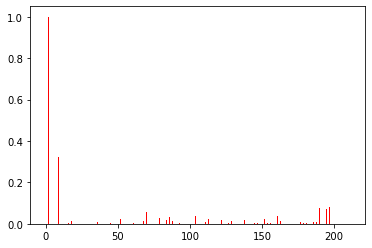

In [10]:
plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight', color='r')

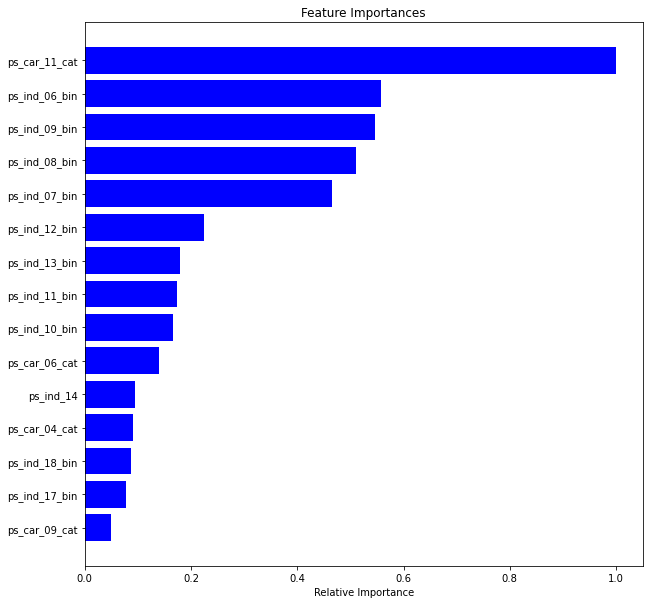

In [14]:
feat_imp = pd.DataFrame({"Col": x_resampled_encoding.columns})
feat_imp["Weights"] = svm_weights

#Group OneHotEncoded features
feat_imp["Col"] = feat_imp["Col"].apply(lambda x: (x.split('cat')[0]+'cat') if 'cat' in x else x)
feat_imp = feat_imp.groupby("Col",as_index=False).sum().sort_values("Weights", ascending=False)
#Scale Weights
feat_imp["FeatImp"] = (
        (feat_imp["Weights"] - feat_imp["Weights"].min())
        / (feat_imp["Weights"].max() - feat_imp["Weights"].min())
    ).round(4)

num_features = 15 
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
# only plot the customized number of features
plt.barh(range(num_features), feat_imp['FeatImp'][:num_features][::-1], color='b', align='center')
plt.yticks(range(num_features), feat_imp['Col'][:num_features][::-1])
plt.xlabel('Relative Importance')
plt.show()

### Selected features

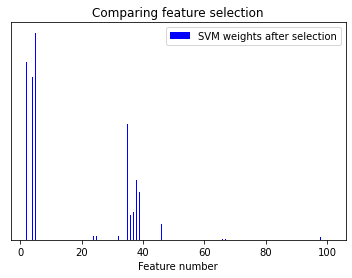

In [11]:
clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(selector.transform(X), Y)

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='b')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

In [20]:
selector.get_support()

array([False, False,  True, False,  True,  True, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False,  True, False, False,  True, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [17]:
svm_weights_selected 

array([0.86080644, 0.78659234, 1.        , 0.28121704, 0.71196529,
       0.01683123, 0.01652907, 0.01197477, 0.016753  , 0.56015671,
       0.11837172, 0.13378936, 0.28769452, 0.23225764, 0.46422308,
       0.07579656, 0.07579656, 0.00443078, 0.00443078, 0.01528849,
       0.01528849, 0.37521584])

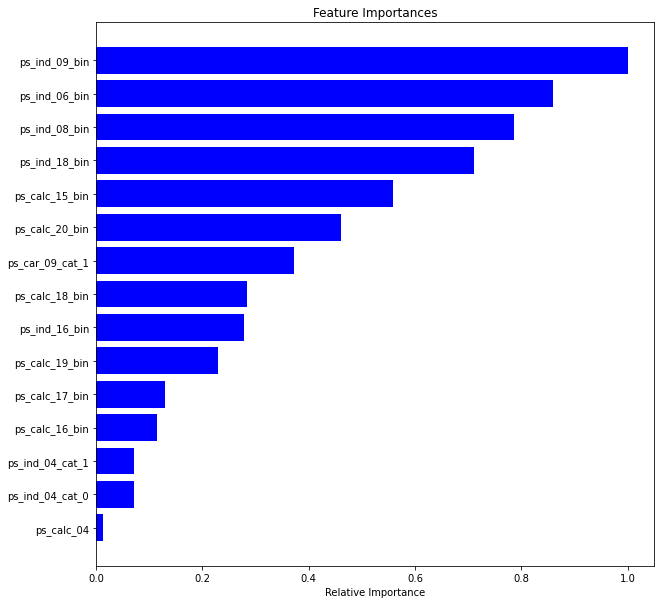

In [31]:
feat_imp = pd.DataFrame({"Col": x_resampled_encoding.columns})
feat_imp["SelectedWeights"]=selector.get_support()
feat_selected=feat_imp[feat_imp["SelectedWeights"]== True]
feat_selected["Weights"]= svm_weights_selected
feat_selected = feat_selected.sort_values("Weights", ascending=False)
feat_selected["FeatImp"] = (
        (feat_selected["Weights"] - feat_selected["Weights"].min())
        / (feat_selected["Weights"].max() -feat_selected["Weights"].min())
    ).round(4)

num_features = 15 
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
# only plot the customized number of features
plt.barh(range(num_features), feat_selected['FeatImp'][:num_features][::-1], color='b', align='center')
plt.yticks(range(num_features), feat_selected['Col'][:num_features][::-1])
plt.xlabel('Relative Importance')
plt.show()

### Data with Resampling and without OneHotEncoding

In [32]:
X = x_resampled.values
Y = np.squeeze(y_resampled.values)
X_train,X_test2,y_train,y_test2=train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler().fit(X_train)
train_sc = scaler.transform(X_train)
test_sc = scaler.transform(X_test2)

svm_clf = LinearSVC(random_state=48) 
start_time = timeit.default_timer()
svm_clf.fit(train_sc,y_train)
elapsed = timeit.default_timer() - start_time
print("Time taken to fit the model in sec is ",elapsed)
y_pred2=svm_clf.predict(test_sc)
print(f"Accuracy score: {accuracy_score(y_test2, y_pred2):.4f}")
print(f"F1 score : {f1_score(y_test2, y_pred2):.4f}")
print(f"Recall score : {recall_score(y_test2, y_pred2):.4f}")
print(f"Precision score : {precision_score(y_test2, y_pred2):.4f}")

Time taken to fit the model in sec is  387.84402040000714
Accuracy score: 0.8889
F1 score : 0.8845
Recall score : 0.8484
Precision score : 0.9238


<AxesSubplot:>

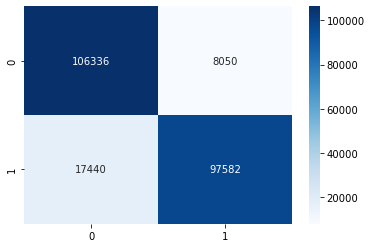

In [34]:
sns.heatmap(confusion_matrix(y_test2,y_pred2),annot=True,fmt='', cmap='Blues')

In [35]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89    114386
           1       0.92      0.85      0.88    115022

    accuracy                           0.89    229408
   macro avg       0.89      0.89      0.89    229408
weighted avg       0.89      0.89      0.89    229408



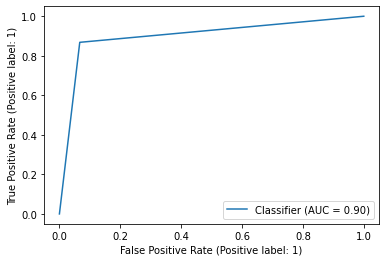

In [36]:
RocCurveDisplay.from_predictions(y_test, y_pred)

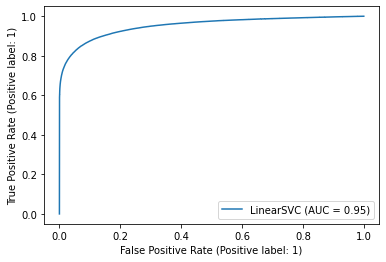

In [37]:
RocCurveDisplay.from_estimator(svm_clf, test_sc, y_test)

### OneHotEncoding improved accuracy

### Change dual and check

In [15]:
svm_clf = LinearSVC(random_state=48,dual=False) 
start_time = timeit.default_timer()
svm_clf.fit(train_sc,y_train)
elapsed = timeit.default_timer() - start_time
print("Time taken to fit the model in sec is ",elapsed)
y_pred2=svm_clf.predict(test_sc)

Time taken to fit the model in sec is  64.24129019999998


In [17]:
print(f"Accuracy score: {accuracy_score(y_test2, y_pred2):.4f}")
print(f"F1 score : {f1_score(y_test2, y_pred2):.4f}")
print(f"Recall score : {recall_score(y_test2, y_pred2):.4f}")
print(f"Precision score : {precision_score(y_test2, y_pred2):.4f}")

Accuracy score: 0.9018
F1 score : 0.8984
Recall score : 0.8664
Precision score : 0.9330


* Changing dual and maxiter has no impact on accuracy score
* Dual=False can resolve the convergence warning

### Performing Cross Validation

In [23]:
svm_clf = LinearSVC(random_state=48,dual=False) 
start_time = timeit.default_timer()
svm_clf.fit(train_sc,y_train)
elapsed = timeit.default_timer() - start_time
print("Time taken to fit the model in sec is ",elapsed)

start_time = timeit.default_timer()
#perform k fold
cv_r2_scores_rf = cross_val_score(svm_clf, X, Y, cv=10,scoring='r2')
elapsed = timeit.default_timer() - start_time
print("Time taken to perform cv for the model in sec is ",elapsed)

print("Cv2 scores:",cv_r2_scores_rf)
print("Mean 5-Fold R Squared: {}".format(np.mean(cv_r2_scores_rf)))

Time taken to fit the model in sec is  65.19228939999994
Time taken to perform cv for the model in sec is  596.9197777000002
Cv2 scores: [0.05488911 0.6682243  0.67090947 0.66442321 0.66982843 0.67007253
 0.67017428 0.67027889 0.67383591 0.66982555]
Mean 5-Fold R Squared: 0.6082461676167825


In [29]:
svm_clf = LinearSVC(random_state=48,dual=False) 
start_time = timeit.default_timer()
svm_clf.fit(train_sc,y_train)
elapsed = timeit.default_timer() - start_time
print("Time taken to fit the model in sec is ",elapsed)

start_time = timeit.default_timer()
#perform k fold
cv_r2_scores_rf = cross_val_score(svm_clf, X, Y, cv=5,scoring='r2')
elapsed = timeit.default_timer() - start_time
print("Time taken to perform cv for the model in sec is ",elapsed)

print("Cv2 scores:",cv_r2_scores_rf)
print("Mean 5-Fold R Squared: {}".format(np.mean(cv_r2_scores_rf)))

Time taken to fit the model in sec is  66.21286610000243
Time taken to perform cv for the model in sec is  257.3644861000066
Cv2 scores: [0.36410239 0.66691513 0.66921672 0.66935621 0.67082086]
Mean 5-Fold R Squared: 0.6080822606911251


* We see that the metrics for all folds in cross_val_score are uniform so it can be concluded that the model is able to generalise